Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/12 12:53:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/12/12 12:53:17 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


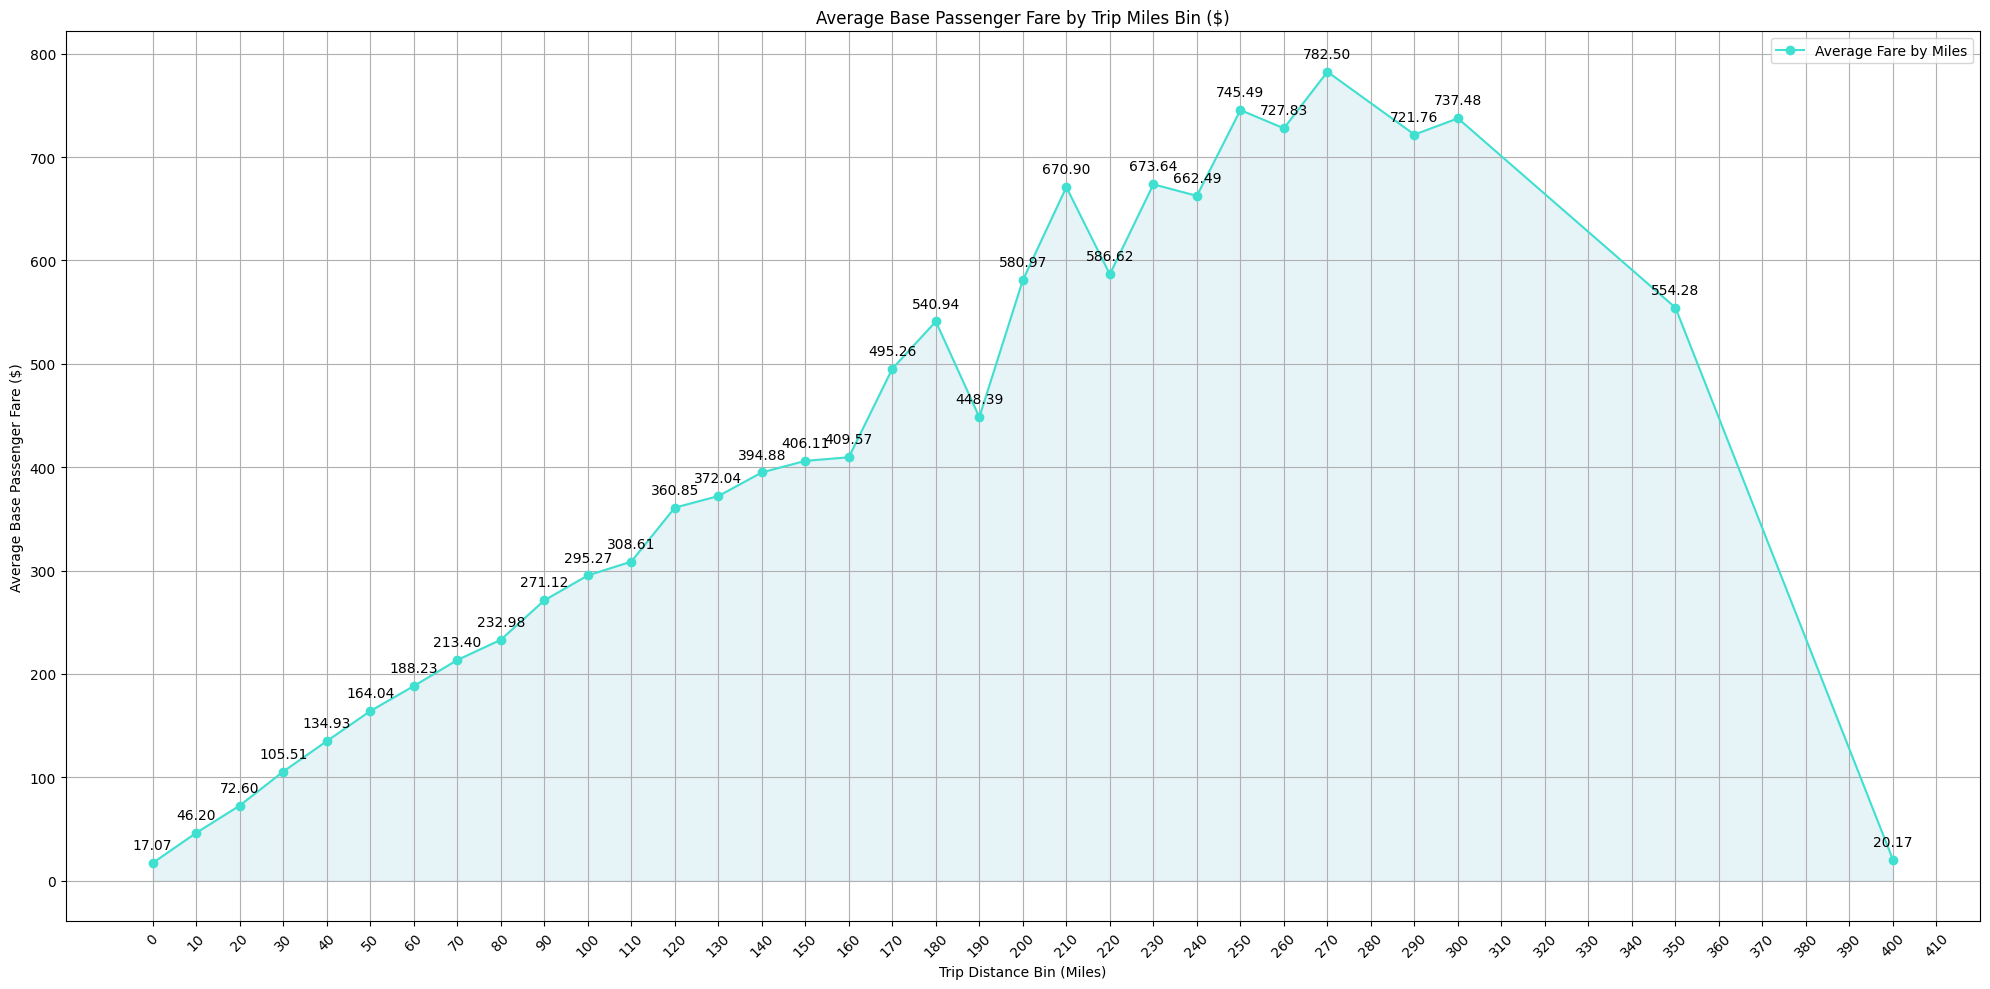

In [1]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, avg

# Initialize Spark session
spark = SparkSession.builder.appName("PricingDynamicsAnalysis").getOrCreate()

# Read the data from HDFS into a DataFrame
df = spark.read.parquet("hdfs://localhost:9000/tmp/hadoop-yuvrajpatadia/dfs/data")

# Select only the necessary columns and filter out any possible outliers or incorrect data
fares_df = df.select("trip_miles", "base_passenger_fare").filter((col("trip_miles") > 0) & (col("base_passenger_fare") > 0))

bin_size = 10

# Define the mile bins (You can adjust the range and bin size as needed)
mile_bins = list(range(0, int(fares_df.agg({"trip_miles": "max"}).collect()[0][0]) + bin_size, bin_size))

# Assign each trip to a bin based on trip_miles
fares_df = fares_df.withColumn("mile_bin", (col("trip_miles") / bin_size).cast("integer") * bin_size)

# Group by the mile bins and calculate the average fare
avg_fare_by_bin = fares_df.groupBy("mile_bin").agg(avg("base_passenger_fare").alias("avg_fare")).orderBy("mile_bin")

# Collect the data to the driver for visualization
avg_fare_by_bin_data = avg_fare_by_bin.toPandas()

# Plotting with Matplotlib
plt.figure(figsize=(20, 10))
plt.plot(avg_fare_by_bin_data['mile_bin'], avg_fare_by_bin_data['avg_fare'], '-o', color='turquoise', label='Average Fare by Miles')
plt.fill_between(avg_fare_by_bin_data['mile_bin'], avg_fare_by_bin_data['avg_fare'], color='lightblue', alpha=0.3)  # For area plot

# Annotate each point with its value
for index, row in avg_fare_by_bin_data.iterrows():
    plt.annotate(
        f"{row['avg_fare']:.2f}",  # Format to 2 decimal places
        (row['mile_bin'], row['avg_fare']),
        textcoords="offset points",  # how to position the text
        xytext=(0, 10),  # distance from text to points (x, y)
        ha="center", 
        size=10,
        color='black')  # horizontal alignment can be left, right or center

# Fix x-axis overlap and set custom ticks
plt.xticks(mile_bins, rotation=45)  # Rotate x-axis labels to prevent overlap
plt.xlabel('Trip Distance Bin (Miles)')
plt.ylabel('Average Base Passenger Fare ($)')
plt.title('Average Base Passenger Fare by Trip Miles Bin ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent cutting off labels
plt.show()

# Stop the Spark session
spark.stop()

23/12/12 12:53:22 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/12/12 12:53:23 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


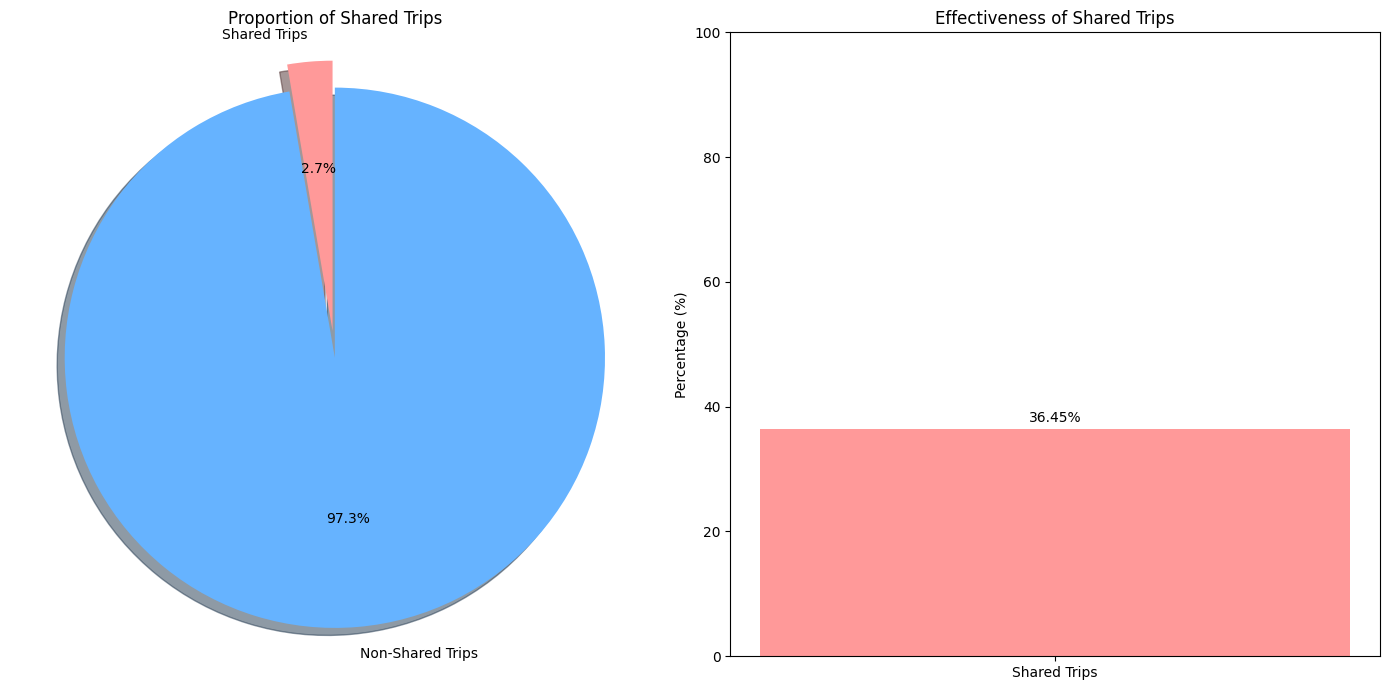

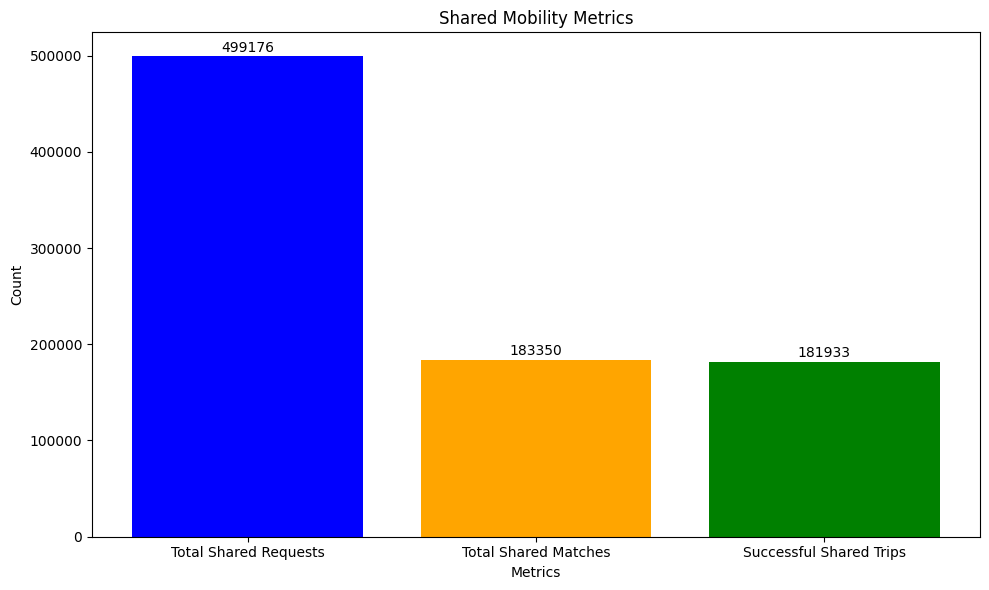

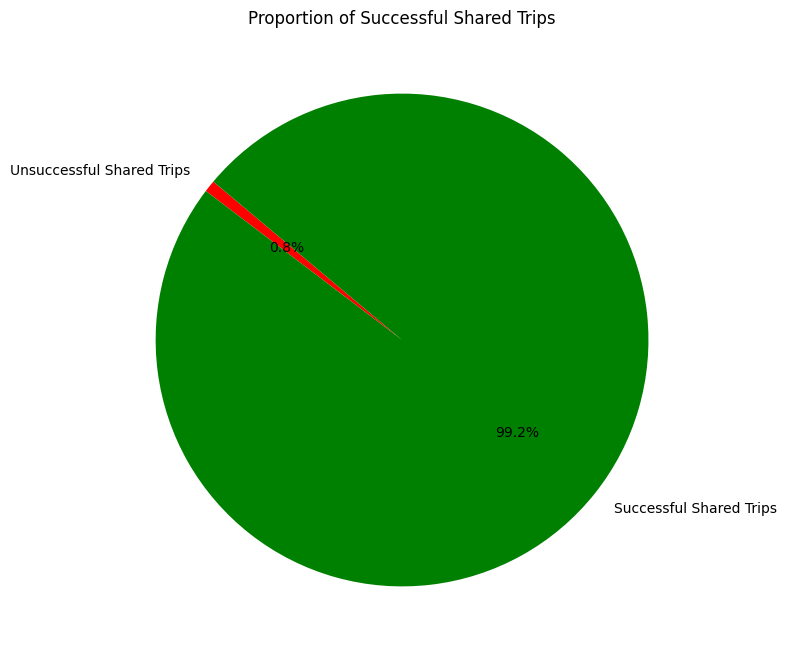

In [2]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, max as spark_max, sum as spark_sum
from pyspark.sql.types import StringType
from pyspark.sql.functions import avg


# Initialize Spark session
spark = SparkSession.builder \
    .appName("SharedMobilityAssessment") \
    .getOrCreate()

# Load your data into a DataFrame
# Replace the path with your actual data path
df = spark.read.parquet("hdfs://localhost:9000/tmp/hadoop-yuvrajpatadia/dfs/data/")

# Create a temporary view so you can use Spark SQL
df.createOrReplaceTempView("fhv_trip_data")

# Shared Trip Proportion
shared_trips_df = df.filter(col("shared_request_flag") == 'Y')
total_shared_trips = shared_trips_df.count()
total_trips = df.count()
shared_trip_proportion = (total_shared_trips / total_trips) * 100

# Effectiveness of Shared Trips
effective_shared_trips = shared_trips_df.filter(col("shared_match_flag") == 'Y').count()
shared_trip_effectiveness = (effective_shared_trips / total_shared_trips) * 100 if total_shared_trips != 0 else 0

# Visualization
# Shared Trip Proportion Pie Chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Pie chart for shared trips proportion
labels = 'Shared Trips', 'Non-Shared Trips'
sizes = [shared_trip_proportion, 100 - shared_trip_proportion]
explode = (0.1, 0)  # explode the 1st slice for emphasis
colors = ['#ff9999','#66b3ff']

ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Proportion of Shared Trips')

# Bar chart for effectiveness of shared trips
labels = ['Shared Trips']
effectiveness = [shared_trip_effectiveness]

ax2.bar(labels, effectiveness, color='#ff9999')
ax2.set_title('Effectiveness of Shared Trips')
ax2.set_ylabel('Percentage (%)')
ax2.set_ylim(0, 100)

# Annotate the bar chart with the percentage value
for i in range(len(effectiveness)):
    ax2.annotate(f'{effectiveness[i]:.2f}%', 
                 xy=(i, effectiveness[i]), 
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom')

# Show the plots
plt.tight_layout()
plt.show()

# Calculate the metrics using Spark SQL
shared_metrics = spark.sql("""
    SELECT 
        SUM(CASE WHEN shared_request_flag = 'Y' THEN 1 ELSE 0 END) AS TotalSharedRequests,
        SUM(CASE WHEN shared_match_flag = 'Y' THEN 1 ELSE 0 END) AS TotalSharedMatches,
        SUM(CASE WHEN shared_request_flag = 'Y' AND shared_match_flag = 'Y' THEN 1 ELSE 0 END) AS SuccessfulSharedTrips
    FROM fhv_trip_data
""")

# Calculate the proportion of matches that resulted in a shared journey
proportion_of_successful_shared_trips = shared_metrics.select(
    (col("SuccessfulSharedTrips") / col("TotalSharedMatches")).alias("ProportionOfSuccessfulSharedTrips")
)

shared_metrics_pd = shared_metrics.toPandas()
proportion_pd = proportion_of_successful_shared_trips.toPandas()

# Plotting the bar chart for raw counts
plt.figure(figsize=(10, 6))
bar_labels = ['Total Shared Requests', 'Total Shared Matches', 'Successful Shared Trips']
bar_values = shared_metrics_pd.iloc[0, :].tolist()
plt.bar(bar_labels, bar_values, color=['blue', 'orange', 'green'])
plt.xlabel('Metrics')
plt.ylabel('Count')
plt.title('Shared Mobility Metrics')
plt.tight_layout()

# Adding the text labels on the bars
for i in range(len(bar_labels)):
    plt.text(i, bar_values[i] + max(bar_values) * 0.01, str(bar_values[i]), ha='center')

plt.show()

# Plotting the pie chart for the proportion of successful shared trips
plt.figure(figsize=(8, 8))
pie_labels = 'Unsuccessful Shared Trips', 'Successful Shared Trips'
pie_values = [1 - proportion_pd.iloc[0, 0], proportion_pd.iloc[0, 0]]
plt.pie(pie_values, labels=pie_labels, autopct='%1.1f%%', startangle=140, colors=['red', 'green'])
plt.title('Proportion of Successful Shared Trips')

plt.show()

# Stop the Spark session
spark.stop()

23/12/12 12:53:26 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


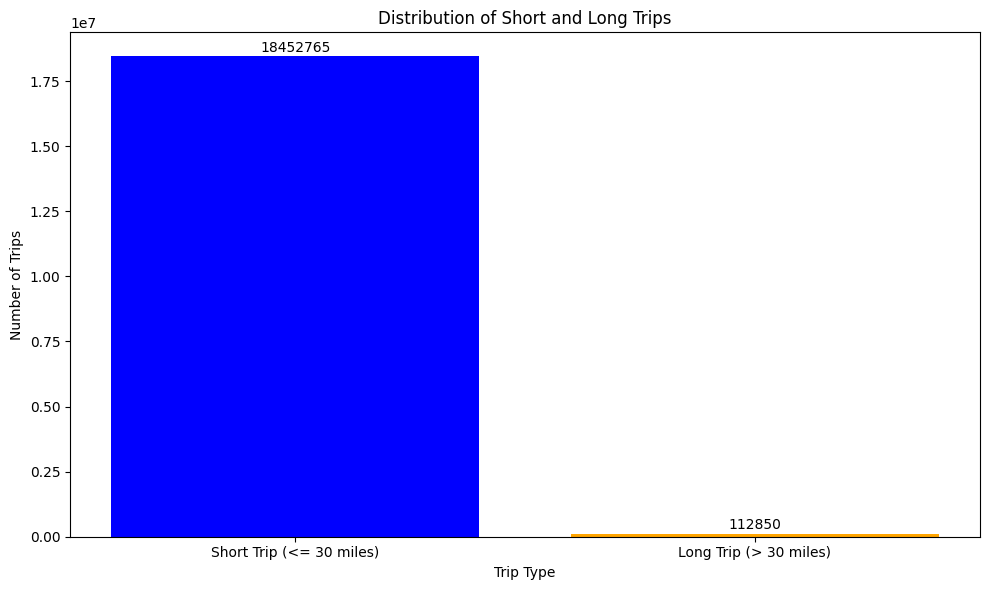

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col
import matplotlib.pyplot as plt

# Initialize Spark session
spark = SparkSession.builder.appName("ShortLongTripsAnalysis").getOrCreate()

# Read the data from HDFS into a DataFrame
df = spark.read.parquet("hdfs://localhost:9000/tmp/hadoop-yuvrajpatadia/dfs/data/")

# Categorize trips into short or long based on the 30-mile criterion
df_with_trip_type = df.withColumn(
    "trip_type",
    when(col("trip_miles") <= 30, "Short Trip (<= 30 miles)").otherwise("Long Trip (> 30 miles)")
)

# Count the number of short and long trips
trip_counts = df_with_trip_type.groupBy("trip_type").count()

# Collect the data to the driver for visualization
trip_counts_local = trip_counts.toPandas()

# Plot the distribution of short and long trips
plt.figure(figsize=(10, 6))
plt.bar(trip_counts_local['trip_type'], trip_counts_local['count'], color=['blue', 'orange'])
plt.xlabel('Trip Type')
plt.ylabel('Number of Trips')
plt.title('Distribution of Short and Long Trips')
plt.tight_layout()

# Adding the text labels on the bars
for i in range(len(trip_counts_local['trip_type'])):
    plt.text(i, trip_counts_local['count'][i] + max(trip_counts_local['count']) * 0.01, str(trip_counts_local['count'][i]), ha='center')


plt.show()

# Stop the Spark session
spark.stop()


In [4]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import pandas as pd

# Initialize Spark session
spark = SparkSession.builder \
    .appName("SparkSQLonHDFSData") \
    .getOrCreate()

# Read the data from HDFS into a DataFrame
df = spark.read.parquet("hdfs://localhost:9000/tmp/hadoop-yuvrajpatadia/dfs/data/")

# Create a temporary view from the DataFrame
df.createOrReplaceTempView("merged_data")

# Analyze the distribution of trip distances
df_dist = spark.sql('SELECT trip_miles FROM merged_data')

# Describe the statistics of trip distances
df_dist.describe().show()

# Histogram of trip distances
trip_miles_hist = df_dist.select('trip_miles').rdd.flatMap(lambda x: x).histogram(20)

# Load the computed histogram into a Pandas DataFrame for plotting
hist_df = pd.DataFrame(
    list(zip(*trip_miles_hist)), 
    columns=['bin', 'frequency']
)

# Format the bin values to have only two decimal points
hist_df['bin'] = hist_df['bin'].apply(lambda x: f"{x:.2f}")

# Reset the index to use integers for plotting, this will make the x-ticks labels clear and horizontal
hist_df.reset_index(inplace=True)

# Plotting
ax = hist_df.plot(
    x='index', y='frequency', kind='bar', figsize=(15, 5), legend=False
)

# Set the x-axis labels to the formatted bin values
ax.set_xticklabels(hist_df['bin'], rotation=0)  # Set rotation to 0 for horizontal labels

# Set the y-scale to logarithmic
ax.set_yscale('log')
ax.set_xlabel('Trip Distance (miles)')
ax.set_ylabel('Count')
ax.set_title('Distribution of Trip Distance')

# Annotate each bar with the bin range and frequency
for idx, row in hist_df.iterrows():
    ax.text(idx, row['frequency'], f"{row['frequency']}", ha='center', va='bottom')

# Display the plot
plt.show()

# Stop the Spark session
spark.stop()


23/12/12 12:53:27 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


+-------+-----------------+
|summary|       trip_miles|
+-------+-----------------+
|  count|         18565615|
|   mean|    4.86722653653|
| stddev|5.644761308497084|
|    min|            0.001|
|    max|          407.563|
+-------+-----------------+



23/12/12 12:53:38 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


23/12/12 12:53:57 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


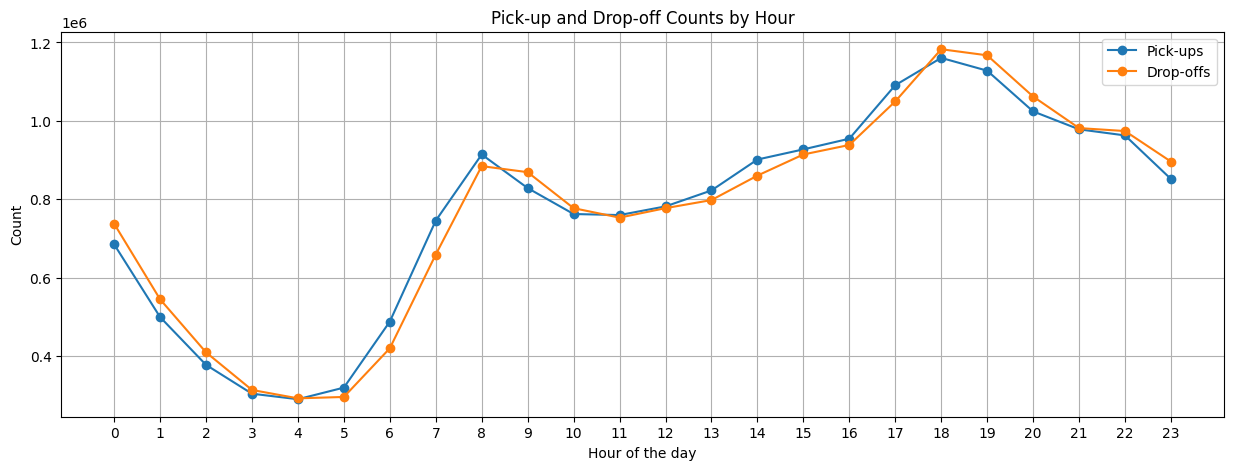

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, hour
import matplotlib.pyplot as plt

# Initialize Spark session
spark = SparkSession.builder \
    .appName("SparkSQLonParquetHDFSData") \
    .getOrCreate()

# Read the data from HDFS into a DataFrame (from Parquet file)
df = spark.read.parquet("hdfs://localhost:9000/tmp/hadoop-yuvrajpatadia/dfs/data/")

# Create a temporary view from the DataFrame
df.createOrReplaceTempView("merged_data")

# Execute the SQL queries for Pickup and Dropoff counts
df_pu = spark.sql('''
    SELECT PULocationID AS LocationID, count(*) AS PUcount
    FROM merged_data
    GROUP BY PULocationID
''')
df_do = spark.sql('''
    SELECT DOLocationID AS LocationID, count(*) AS DOcount
    FROM merged_data
    GROUP BY DOLocationID
''')

# Perform an outer join on LocationID
df_q = df_pu.join(df_do, "LocationID", "outer")

# Find the top 50 pickup and dropoff locations
PUtop = df_q.orderBy(col("PUcount").desc())
DOtop = df_q.orderBy(col("DOcount").desc())

# Collect data to the driver node for plotting
PUtop_local = PUtop.toPandas()
DOtop_local = DOtop.toPandas()

# Add a new column with the hour of pickup and dropoff, then group by this new column
df_pu_spark = spark.sql('''
    SELECT hour(pickup_datetime) AS hour, count(*) AS PUcount
    FROM merged_data
    GROUP BY hour(pickup_datetime)
''')
df_do_spark = spark.sql('''
    SELECT hour(dropoff_datetime) AS hour, count(*) AS DOcount
    FROM merged_data
    GROUP BY hour(dropoff_datetime)
''')

# Perform a join operation on the 'hour' column
df_q2_spark = df_pu_spark.join(df_do_spark, "hour", "outer").fillna(0)

# Sort the values by 'hour'
df_q2_spark = df_q2_spark.orderBy("hour")

# Collect data to the driver node for plotting
df_q2_pandas = df_q2_spark.toPandas()

# Plotting with Matplotlib
plt.figure(figsize=(15,5))
plt.plot(df_q2_pandas['hour'], df_q2_pandas['PUcount'], '-o', label='Pick-ups')
plt.plot(df_q2_pandas['hour'], df_q2_pandas['DOcount'], '-o', label='Drop-offs')
plt.xlabel('Hour of the day')
plt.ylabel('Count')
plt.title('Pick-up and Drop-off Counts by Hour')
plt.xticks(range(24))  # Set x-axis ticks to show every hour
plt.legend()
plt.grid(True)

plt.show()

# Stop the Spark session
spark.stop()


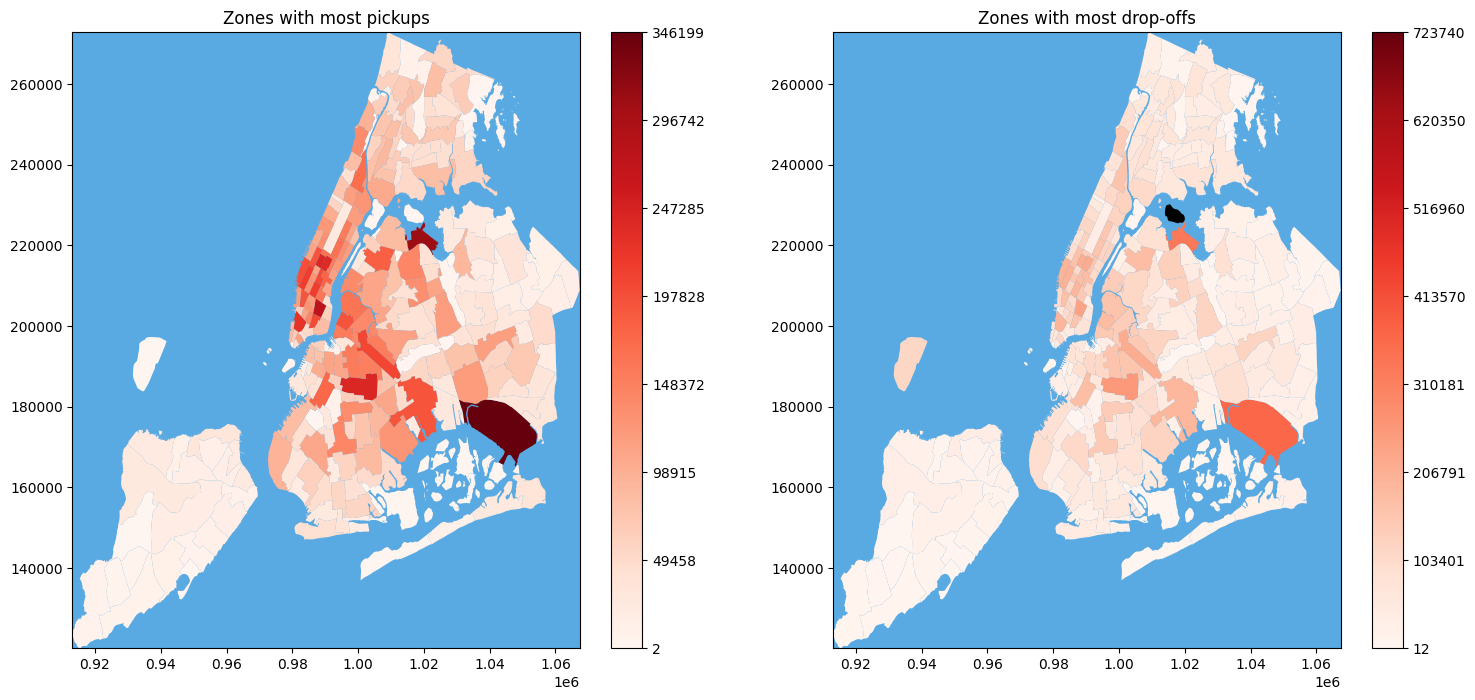

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Polygon as PolygonPatch
import shapefile
import numpy as np
import shapefile
import pandas as pd

def get_boundaries(sf):
    lat, lon = [], []
    for shape in list(sf.iterShapes()):
        lat.extend([shape.bbox[0], shape.bbox[2]])
        lon.extend([shape.bbox[1], shape.bbox[3]])

    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    return lat_min, lat_max, lon_min, lon_max

def get_lat_lon(sf):
    content = []
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        
        content.append((loc_id, x, y))
    return pd.DataFrame(content, columns=["LocationID", "longitude", "latitude"])

def draw_zone_map(ax, sf, heat={}, text=[], arrows=[]):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)
    theta = np.linspace(0, 2*np.pi, len(text)+1).tolist()
    ax.set_facecolor(ocean)
    
    # colorbar
    if len(heat) != 0:
        heat_values = list(heat.values())  # Make sure heat.values() is a flat list of numbers
        vmin = min(heat_values)
        vmax = max(heat_values)
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        cm = plt.get_cmap('Reds')
        sm = mpl.cm.ScalarMappable(cmap=cm, norm=norm)
        sm.set_array([])
        # Use 'fig.colorbar' instead of 'plt.colorbar'
        cbar = fig.colorbar(sm, ax=ax, ticks=np.linspace(vmin, vmax, 8), 
                            boundaries=np.arange(vmin - 10, vmax + 10, .1))
        cbar.ax.set_yticklabels([f'{int(tick)}' for tick in cbar.get_ticks()])  # Set the colorbar labels as integers

    # Proceed with plotting shapes and annotations
    # ... (rest of the function remains the same)
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]  # Update with correct index or field name
        zone = rec[shp_dic['zone']]  # Update with correct index or field name
        
        if len(heat) == 0:
            col = continent
        else:
            if loc_id not in heat:
                R, G, B, A = cm(norm(0))
            else:
                R, G, B, A = cm(norm(heat[loc_id]))
            col = [R, G, B]

        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = PolygonPatch(shape.points, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(polygon)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts - 1:
                    i1 = shape.parts[ip + 1] - 1
                else:
                    i1 = len(shape.points)

                polygon = PolygonPatch(shape.points[i0:i1+1], facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(polygon)
        
        x = (shape.bbox[0] + shape.bbox[2]) / 2
        y = (shape.bbox[1] + shape.bbox[3]) / 2
        if len(text) == 0:
            plt.text(x, y, str(loc_id), horizontalalignment='center', verticalalignment='center')
        elif len(text) != 0 and loc_id in text:
            eta_x = 0.05 * np.cos(theta[text.index(loc_id)])
            eta_y = 0.05 * np.sin(theta[text.index(loc_id)])
            ax.annotate("[{}] {}".format(loc_id, zone), xy=(x, y), xytext=(x+eta_x, y+eta_y),
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12,
                        arrowprops=dict(facecolor='black', width=3, shrink=0.05))
    if len(arrows) != 0:
        for arr in arrows:
            ax.annotate('', xy=arr['dest'], xytext=arr['src'], size=arr['cnt'],
                        arrowprops=dict(arrowstyle="fancy", fc="0.6", ec="none"))
    
    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])


sf = shapefile.Reader("taxi_zones.shp")
fields_name = [field[0] for field in sf.fields[1:]]

shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))

attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf).set_index("LocationID"), on="LocationID")
df_loc.head()

# Convert the all DataFrames to dictionaries mapping LocationID to PUcount and DOcount
PUtop_dict = dict(zip(PUtop_local['LocationID'], PUtop_local['PUcount']))
DOtop_dict = dict(zip(DOtop_local['LocationID'], DOtop_local['DOcount']))

# Load the shapefile
sf = shapefile.Reader("taxi_zones.shp")

# Create the figure and subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,8))

# Plot for pickups
axes[0].set_title("Zones with most pickups")
draw_zone_map(axes[0], sf, heat=PUtop_dict, text=[str(loc_id) for loc_id in PUtop_dict.keys()])

# Plot for drop-offs
axes[1].set_title("Zones with most drop-offs")
draw_zone_map(axes[1], sf, heat=DOtop_dict, text=[str(loc_id) for loc_id in DOtop_dict.keys()])

# Set boundaries for the axes based on the shapefile boundaries
boundaries = get_boundaries(sf)
for ax in axes:
    ax.set_xlim([boundaries[0], boundaries[1]])
    ax.set_ylim([boundaries[2], boundaries[3]])

plt.show()